# Homeostatic STDP

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/Ramp.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/Ramp.ipynb)

In [1]:
#!pip install ANNarchy

This example is a reimplementation of the mechanism described in:

> Carlson, K.D.; Richert, M.; Dutt, N.; Krichmar, J.L., "Biologically plausible models of homeostasis and STDP: Stability and learning in spiking neural networks," in Neural Networks (IJCNN), The 2013 International Joint Conference on , vol., no., pp.1-8, 4-9 Aug. 2013. doi: 10.1109/IJCNN.2013.6706961

It is based on the corresponding Carlsim tutorial:

http://www.socsci.uci.edu/~jkrichma/CARLsim/doc/tut3_plasticity.html

This notebook focuses on the simple "Ramp" experiment, but the principle is similar for the self-organizing receptive fields (SORF) in the next notebook.

In [2]:
import numpy as np

import ANNarchy as ann
ann.clear()

ANNarchy 4.8 (4.8.0) on darwin (posix).


The network uses regular-spiking Izhikevich neurons (see the `Izhikevich` notebook), but using exponentially-decaying conductances and NMDA synapses:

In [3]:
RSNeuron = ann.Neuron(
    parameters = """
        a = 0.02 : population
        b = 0.2 : population
        c = -65. : population
        d = 8. : population
        tau_ampa = 5. : population
        tau_nmda = 150. : population
        vrev = 0.0 : population
    """ ,
    equations="""
        # Inputs
        I = g_ampa * (vrev - v) + g_nmda * nmda(v, -80.0, 60.0) * (vrev -v)  
        # Membrane potential and recovery variable are solved using the midpoint method for stability     
        dv/dt = (0.04 * v + 5.0) * v + 140.0 - u + I : init=-65., midpoint
        du/dt = a * (b*v - u) : init=-13., midpoint
        # AMPA and NMDA conductances
        tau_ampa * dg_ampa/dt = -g_ampa : exponential
        tau_nmda * dg_nmda/dt = -g_nmda : exponential
    """ , 
    spike = """
        v >= 30.
    """, 
    reset = """
        v = c
        u += d
    """,
    functions = """
        nmda(v, t, s) = ((v-t)/(s))^2 / (1.0 + ((v-t)/(s))^2)
    """
)

The main particularity about NMDA synaptic models is that a single synaptic connection influences two conductances:

1) The AMPA conductance, which primarily drives the post-synaptic neuron:

$$
    I_\text{AMPA} = g_\text{AMPA} \times (V_\text{rev} - V)
$$

2) The NMDA conductance, which is non-linearly dependent on the membrane potential:

$$
    I_\text{NMDA} = g_\text{NMDA} \times \frac{(\frac{V - V_\text{NMDA}}{\sigma})^2}{1 + (\frac{V - V_\text{NMDA}}{\sigma})^2} \times (V_\text{rev} - V)
$$

In short, the NMDA conductance only increases if the post-synaptic neuron is already depolarized.

The `nmda` function is defined in the `functions` argument for readability. The parameters $V_\text{NMDA} =-80 \text{mV}$ and $\sigma = 60 \text{mV}$ are here hardcoded in the equation, but they could be defined as global parameters.

The AMPA and NMDA conductances are exponentially decreasing with different time constants:

$$
    \tau_\text{AMPA} \frac{dg_\text{AMPA}(t)}{dt} + g_\text{AMPA}(t) = 0
$$
$$
    \tau_\text{NMDA} \frac{dg_\text{NMDA}(t)}{dt} + g_\text{NMDA}(t) = 0
$$

Another thing to notice in this neuron model is that the differential equations for the membrane potential and recovery variable are solved concurrently using the midpoint numerical method for stability: the semi-implicit method initially proposed by Izhikevich would fail.

The input of the network is a population of 100 Poisson neurons, whose firing rate vary linearly from 0.2 to 20 Hz:

In [4]:
# Input population
inp = ann.PoissonPopulation(100, rates=np.linspace(0.2, 20., 100))

We will consider two RS neurons, one learning inputs from the Poisson population using the regular STDP, the other learning using the proposed homeostatic STDP:

In [5]:
# RS neuron without homeostatic mechanism
pop1 = ann.Population(1, RSNeuron)

# RS neuron with homeostatic mechanism
pop2 = ann.Population(1, RSNeuron)

The regular STDP used in the article is a nearest-neighbour variant, which integrates LTP and LTD traces triggered after each pre- or post-synaptic spikes, respectively.

Contrary to the STDP synapse provided by ANNarchy, weight changes occur at each each time step:

* In a post-pre interval, weight changes follow the LTP trace,
* In a pre-post interval, weight changes follow the LTD trace.

The weights are clipped between 0 and $w_\text{max}$.

In [6]:
nearest_neighbour_stdp = ann.Synapse(
    parameters="""
        tau_plus = 20. : projection
        tau_minus = 60. : projection
        A_plus = 0.0002 : projection
        A_minus = 0.000066 : projection
        w_max = 0.03 : projection
    """,
    equations = """
        # Traces
        tau_plus  * dltp/dt = -ltp : exponential
        tau_minus * dltd/dt = -ltd : exponential
        # Nearest-neighbour
        w += if t_post >= t_pre: ltp else: - ltd : min=0.0, max=w_max
    """,
    pre_spike="""
        g_target += w
        ltp = A_plus
    """,         
    post_spike="""
        ltd = A_minus 
    """
)

The homeostatic STDP rule proposed by Carlson et al. is more complex. It has a regular STDP part (the nearest-neighbour variant above) and a homeostatic regularization part, ensuring that the post-synaptic firing rate $R$ does not exceed a target firing rate $R_\text{target}$ = 35 Hz.

The firing rate of a spiking neuron can be automatically computed by ANNarchy (see later). It is then accessible as the variable `r` of the neuron (as if it were a regular rate-coded neuron).

The homeostatic STDP rule is defined by:

$$
    \Delta w = K \, (\alpha  \, (1 - \frac{R}{R_\text{target}}) \, w + \beta \, \text{stdp} )
$$

where stdp is the regular STDP weight change, and $K$ is a firing rate-dependent learning rate:

$$
    K =  \frac{R}{ T \, (1 + |1 - \gamma \, \frac{R}{R_\text{target}}|})
$$

with $T$ being the window over which the mean firing rate is computed (5 seconds) and $\alpha$, $\beta$, $\gamma$ are parameters.

In [7]:
homeo_stdp = ann.Synapse(
    parameters="""
        # STDP
        tau_plus = 20. : projection
        tau_minus = 60. : projection
        A_plus = 0.0002 : projection
        A_minus = 0.000066 : projection
        w_min = 0.0 : projection
        w_max = 0.03 : projection

        # Homeostatic regulation
        alpha = 0.1 : projection
        beta = 1.0 : projection
        gamma = 50. : projection
        Rtarget = 35. : projection
        T = 5000. : projection
    """,
    equations = """
        # Traces
        tau_plus  * dltp/dt = -ltp : exponential
        tau_minus * dltd/dt = -ltd : exponential
        # Homeostatic values
        R = post.r : postsynaptic
        K = R/(T*(1.+fabs(1. - R/Rtarget) * gamma)) : postsynaptic
        # Nearest-neighbour
        stdp = if t_post >= t_pre: ltp else: - ltd 
        w += (alpha * w * (1- R/Rtarget) + beta * stdp ) * K : min=w_min, max=w_max
    """,
    pre_spike="""
        g_target += w
        ltp = A_plus
    """,         
    post_spike="""
        ltd = A_minus 
    """ 
)

This rule necessitates that the post-synaptic neurons compute their average firing rate over a 5 seconds window. This has to be explicitely enabled, as it would be computationally too expensive to allow it by default:

In [8]:
pop1.compute_firing_rate(5000.)
pop2.compute_firing_rate(5000.)

We can now fully connect the input population to the two neurons with random weights:

In [9]:
# Projection without homeostatic mechanism
proj1 = ann.Projection(inp, pop1, ['ampa', 'nmda'], synapse=nearest_neighbour_stdp)
proj1.connect_all_to_all(ann.Uniform(0.01, 0.03))

# Projection with homeostatic mechanism
proj2 = ann.Projection(inp, pop2, ['ampa', 'nmda'], synapse=homeo_stdp)
proj2.connect_all_to_all(weights=ann.Uniform(0.01, 0.03))

Note that the same weights will target both AMPA and NMDA conductances in the post-synaptic neurons. By default, the argument `target` of Projection should be a string, but you can also pass a list of strings to reach several conductances with the same weights.

We can now compile and simulate for 1000 seconds while recording the relevat information:

In [10]:
ann.compile()

Compiling ...  OK 


In [11]:
# Record
m1 = ann.Monitor(pop1, 'r')
m2 = ann.Monitor(pop2, 'r')
m3 = ann.Monitor(proj1[0], 'w', period=1000.)
m4 = ann.Monitor(proj2[0], 'w', period=1000.)

# Simulate
T = 1000 # 1000s
ann.simulate(T*1000., True)

# Get the data
data1 = m1.get('r')
data2 = m2.get('r')
data3 = m3.get('w')
data4 = m4.get('w')

print('Mean Firing Rate without homeostasis:', np.mean(data1[:, 0]))
print('Mean Firing Rate with homeostasis:', np.mean(data2[:, 0]))

Simulating 1000.0 seconds of the network took 1.0424680709838867 seconds. 
Mean Firing Rate without homeostasis: 55.664001199999994
Mean Firing Rate with homeostasis: 35.21585360000001


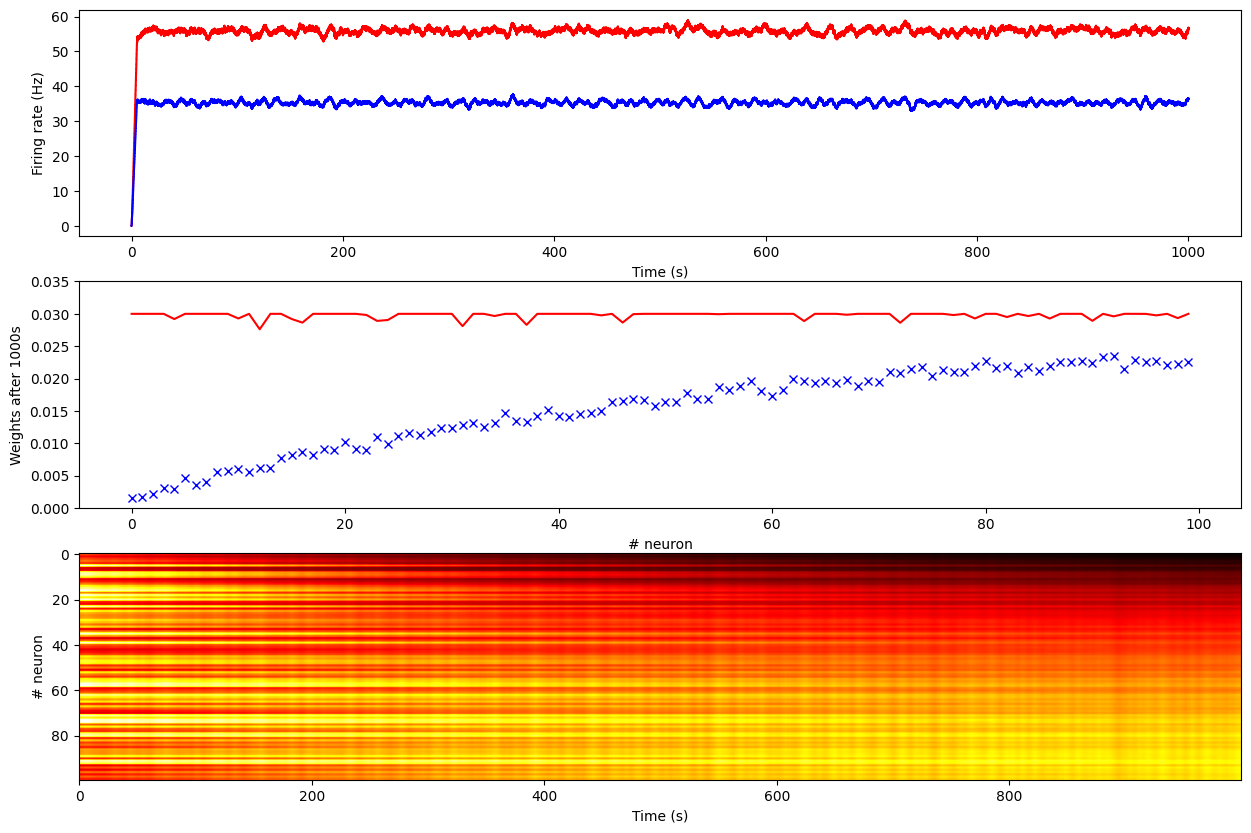

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

plt.subplot(311)
plt.plot(np.linspace(0, T, len(data1[:, 0])), data1[:, 0], 'r-', label="Without homeostasis")
plt.plot(np.linspace(0, T, len(data2[:, 0])), data2[:, 0], 'b-', label="With homeostasis")
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')

plt.subplot(312)
plt.plot(data3[-1, :], 'r-')
plt.plot(data4[-1, :], 'bx')
axes = plt.gca()
axes.set_ylim([0., 0.035])
plt.xlabel('# neuron')
plt.ylabel('Weights after 1000s')

plt.subplot(313)
plt.imshow(np.array(data4, dtype='float').T, aspect='auto', cmap='hot')
plt.xlabel('Time (s)')
plt.ylabel('# neuron')
plt.show()

We see that without homeostasis, the post-synaptic neuron reaches quickly a firing of 55 Hz, with all weights saturating at their maximum value 0.03. This is true even for inputs as low as 0.2Hz.

Meanwhile, with homeostasis, the post-synaptic neuron gets a firing rate of 35 Hz (its desired value), and the weights from the input population are proportional to the underlying activity.